## Header 
Author : Amina Matt and Yichen Wang  
Date created : 14.10.2021  
Date last modified : 14.10.2021  
Python version : 3.8  
Description : Text processing of the CARICOM Compilation Archive (CCA) https://louverture.ch/cca/ 



The Natural Language Toolkit is a library for natural language programming in Python 

In [2]:
# -*- coding: utf-8 -*-

import nltk 
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree
from nltk.tree import Tree


## Named Entities Recognition with NER Stanford 

In [3]:
#Stanford NER 
NER_FOLDER = './NER-Standford/stanford-ner-2020-11-17'
CLASSIFIER_PATH = NER_FOLDER+'/classifiers/'
JAR_PATH = NER_FOLDER+'/stanford-ner.jar'

#classifiers
classifier_3 = 'english.all.3class.distsim.crf.ser.gz'#3 class model for recognizing locations, persons, and organizations
classifier_4 = 'english.conll.4class.distsim.crf.ser.gz'#4 class model for recognizing locations, persons, organizations, and miscellaneous entities
classifier_7 = 'english.muc.7class.distsim.crf.ser.gz' #7 class model for recognizing locations, persons, organizations, times, money, percents, and dates

st = StanfordNERTagger(CLASSIFIER_PATH+classifier_7, JAR_PATH, encoding='utf-8')

#Text retrieving
DATA_FOLDER = './data/'
caricom_sample = DATA_FOLDER +'Caricom_Archive_Sample.txt'
caricom = DATA_FOLDER +'Caricom_Archive.txt'

#Extracting named-entities
text = open(caricom_sample, 'r').read()
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('=', 'O'), ('>', 'O'), ('Hans', 'PERSON'), ('Conrad', 'PERSON'), ('Hottinger', 'PERSON'), ('’', 'O'), ('s', 'O'), ('business', 'O'), ('partner', 'O'), ('was', 'O'), ('Denis', 'ORGANIZATION'), ('de', 'ORGANIZATION'), ('Rougemont', 'ORGANIZATION'), ('(', 'O'), ('1759\xad–1839', 'O'), (')', 'O'), ('from', 'O'), ('Saint-Aubin', 'O'), ('and', 'O'), ('Neuchâtel', 'ORGANIZATION'), (',', 'O'), ('banker', 'O'), (',', 'O'), ('Prussian', 'O'), ('financial', 'O'), ('agent', 'O'), (',', 'O'), ('major', 'O'), ('Banque', 'O'), ('de', 'O'), ('France', 'LOCATION'), ('shareholder', 'O'), ('and', 'O'), ('real', 'O'), ('estate', 'O'), ('owner', 'O'), ('in', 'O'), ('Paris', 'LOCATION'), ('and', 'O'), ('Berne', 'LOCATION'), ('.', 'O'), ('He', 'O'), ('bought', 'O'), ('the', 'O'), ('Hôtel', 'ORGANIZATION'), ('DuPeyrou', 'ORGANIZATION'), ('in', 'O'), ('Neuchâtel', 'O'), ('in', 'O'), ('1816', 'DATE'), ('.', 'O'), ('In', 'O'), ('1837', 'DATE'), (',', 'O'), ('his', 'O'), ('son', 'O'), ('Abraham', 'PERSON'), ('D

At this point the whole text is tagged. However the entities aren't grouped together. For example, a person full name is separate into two tuples.

## BIO tagging for readable Named Entities (i.e. regrouped NE)

[BIO](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) tags are a way to regroup tokens, to make the output more readable. 
A person name with first and last name should be regroup by assigning  
 -B to the beginning of named entities  
 -I assigned to inside  
 -O assigned to other  
This is done by checking the tokens just before and after the one of interest.

In [4]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
		bio_tagged = [] #empty list
		prev_tag = "O" #starting with a O tag
		for token, tag in ne_tagged:
			if tag == "O": #O
				bio_tagged.append((token, tag))
				prev_tag = tag
				continue
			if tag != "O" and prev_tag == "O": # Begin NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag == tag: # Inside NE
				bio_tagged.append((token, "I-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
		return bio_tagged

In [5]:
bio_text = bio_tagger(classified_text)
bio_text

[('=', 'O'),
 ('>', 'O'),
 ('Hans', 'B-PERSON'),
 ('Conrad', 'I-PERSON'),
 ('Hottinger', 'I-PERSON'),
 ('’', 'O'),
 ('s', 'O'),
 ('business', 'O'),
 ('partner', 'O'),
 ('was', 'O'),
 ('Denis', 'B-ORGANIZATION'),
 ('de', 'I-ORGANIZATION'),
 ('Rougemont', 'I-ORGANIZATION'),
 ('(', 'O'),
 ('1759\xad–1839', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Saint-Aubin', 'O'),
 ('and', 'O'),
 ('Neuchâtel', 'B-ORGANIZATION'),
 (',', 'O'),
 ('banker', 'O'),
 (',', 'O'),
 ('Prussian', 'O'),
 ('financial', 'O'),
 ('agent', 'O'),
 (',', 'O'),
 ('major', 'O'),
 ('Banque', 'O'),
 ('de', 'O'),
 ('France', 'B-LOCATION'),
 ('shareholder', 'O'),
 ('and', 'O'),
 ('real', 'O'),
 ('estate', 'O'),
 ('owner', 'O'),
 ('in', 'O'),
 ('Paris', 'B-LOCATION'),
 ('and', 'O'),
 ('Berne', 'B-LOCATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('bought', 'O'),
 ('the', 'O'),
 ('Hôtel', 'B-ORGANIZATION'),
 ('DuPeyrou', 'I-ORGANIZATION'),
 ('in', 'O'),
 ('Neuchâtel', 'O'),
 ('in', 'O'),
 ('1816', 'B-DATE'),
 ('.', 'O'),
 ('In', 'O'),
 ('1837

Using the BIO tags we can recreate a tokens list with regrouped/readable named entities. 

In [6]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Create tree       
def stanford_tree(bio_tagged):
	tokens, ne_tags = zip(*bio_tagged)
	pos_tags = [pos for token, pos in pos_tag(tokens)]

	conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
	ne_tree = conlltags2tree(conlltags) #from BIO to tree format
	return ne_tree

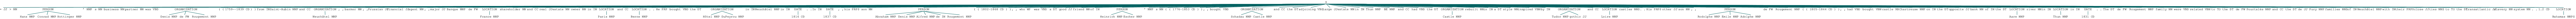

In [7]:
tree_text = stanford_tree(bio_text)
tree_text

In [39]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Parse named entities from tree
def structure_ne(ne_tree):
	ne = []
	for subtree in ne_tree:
		if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
			ne_label = subtree.label()
			ne_string = " ".join([token for token, pos in subtree.leaves()])
			ne.append((ne_string, ne_label))
		else:
			ne_label = 'O'
			ne_string = subtree[0]
			ne.append((ne_string, ne_label))           
	return ne

In [40]:
clean_ne = structure_ne(tree_text)
clean_ne

[('=', 'O'),
 ('>', 'O'),
 ('Hans Conrad Hottinger', 'PERSON'),
 ('’', 'O'),
 ('s', 'O'),
 ('business', 'O'),
 ('partner', 'O'),
 ('was', 'O'),
 ('Denis de Rougemont', 'ORGANIZATION'),
 ('(', 'O'),
 ('1759\xad–1839', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Saint-Aubin', 'O'),
 ('and', 'O'),
 ('Neuchâtel', 'ORGANIZATION'),
 (',', 'O'),
 ('banker', 'O'),
 (',', 'O'),
 ('Prussian', 'O'),
 ('financial', 'O'),
 ('agent', 'O'),
 (',', 'O'),
 ('major', 'O'),
 ('Banque', 'O'),
 ('de', 'O'),
 ('France', 'LOCATION'),
 ('shareholder', 'O'),
 ('and', 'O'),
 ('real', 'O'),
 ('estate', 'O'),
 ('owner', 'O'),
 ('in', 'O'),
 ('Paris', 'LOCATION'),
 ('and', 'O'),
 ('Berne', 'LOCATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('bought', 'O'),
 ('the', 'O'),
 ('Hôtel DuPeyrou', 'ORGANIZATION'),
 ('in', 'O'),
 ('Neuchâtel', 'O'),
 ('in', 'O'),
 ('1816', 'DATE'),
 ('.', 'O'),
 ('In', 'O'),
 ('1837', 'DATE'),
 (',', 'O'),
 ('his', 'O'),
 ('son', 'O'),
 ('Abraham Denis Alfred de Rougemont', 'PERSON'),
 ('(', 'O'),
 ('180

# From NE tree to JSON

The structure NE list for each text is transformed into an entry in a dataframe. The goal is to have for each sample of text an entry with the *relevant* informations.  
The difficult part is to sort the relevant informations. Which of the persons is the one of interest? Which location is the location where the organization or the person was involved? Which dates are the dates of interest? 
Here we deal only with the transformation.

## Compute how many items follow the **(*name* (date) from *origin*)** schema (schema 1)

## Use schema 1 **(*name* (date) from *origin*)** to retrieve JSON names, origins and dates attributes in the text item.

## Use section name to retrieve JSON colonial location attribute

To do 

## Use predefined categories to retrieve the JSON type attribute 

To do 

# Scratch

What about multiple persons in a paragraph?
    -> one ID per person with same organization groups etc...

In [ ]:
dataSet = pd.DataFrame({
                     'id':[],
                     'person':[],
                     'location':[],
                     'period':[],})
dataSet.

In [ ]:
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

In [ ]:
len(classified_text)

In [ ]:
json